In [106]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets,transforms
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
import torch.nn.functional as F

 # Decide whether to run on GPU or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [107]:
ROW_IMG = 10
N_ROWS = 5

In [108]:
class LeNet5(nn.Module):

    def __init__(self):
        super(LeNet5, self).__init__()
        
        self.layering = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh()
        )

        self.classify = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=10),
        )


    def forward(self, x):
        x = self.layering(x)
        x = torch.flatten(x, 1)
        x = self.classify(x)
        x = F.softmax(x, dim=1)
        return x

In [109]:
batch_size = 64
# define transforms
# transforms.ToTensor() automatically scales the images to [0,1] range
transforms = transforms.Compose([transforms.Resize((32, 32)),
                                 transforms.ToTensor()])

# download and create datasets
train_dataset = datasets.MNIST('./data', 
                               train=True, 
                               transform=transforms,
                               download=True)

test_dataset = datasets.MNIST('./data', 
                               train=False, 
                               transform=transforms)

# define the data loaders
train_loader =  torch.utils.data.DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)

test_loader =  torch.utils.data.DataLoader(dataset=test_dataset, 
                          batch_size=batch_size, 
                          shuffle=False)

In [110]:
LEARNING_RATE = 0.001
model = LeNet5().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()


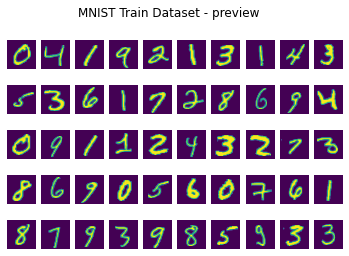

In [111]:
fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(train_dataset.data[index])
fig.suptitle('MNIST Train Dataset - preview');

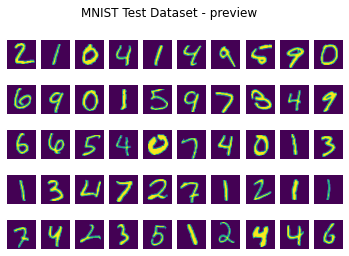

In [112]:
fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(test_dataset.data[index])
fig.suptitle('MNIST Test Dataset - preview');

In [113]:
Epoch =10
train_loss = []
val_loss = []

for epoch in range(Epoch):
   
    total_train_loss = 0
    validation_total_loss = 0

    model.train()
    
    # training our model
    for idx, (image, label) in enumerate(train_loader):

        image, label = image.to(device), label.to(device)
        optimizer.zero_grad()
        pred = model(image)

        loss = criterion(pred, label)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

    total_train_loss = total_train_loss / (idx + 1)
    train_loss.append(total_train_loss)
    
    # validating our model
    model.eval()
    total = 0
    for idx, (image, label) in enumerate(test_loader):
        image, label = image.to(device), label.to(device)
        pred = model(image)
        loss = criterion(pred, label)
        validation_total_loss += loss.item()

        pred = torch.nn.functional.softmax(pred, dim=1)
        for i, p in enumerate(pred):
            if label[i] == torch.max(p.data, 0)[1]:
                total = total + 1

    accuracy = total / len(test_dataset)

    validation_total_loss = validation_total_loss / (idx + 1)
    val_loss.append(validation_total_loss)

    if epoch % 5 == 0:
      print('\nEpoch: {}/{}, Train Loss: {:.4f}, Val Loss: {:.4f}, Val Acc: {:.4f}'.format(epoch, Epoch, total_train_loss, validation_total_loss, accuracy))


Epoch: 0/10, Train Loss: 1.5802, Val Loss: 1.5103, Val Acc: 0.9553

Epoch: 5/10, Train Loss: 1.4776, Val Loss: 1.4767, Val Acc: 0.9853


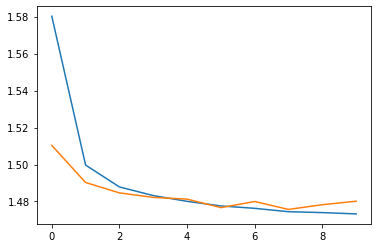

In [114]:
plt.plot(train_loss)
plt.plot(val_loss)

In [115]:
testiter = iter(test_loader)
images, labels = testiter.next()
with torch.no_grad():
  images, labels = images.to(device), labels.to(device)
  preds = model(images)

In [116]:
images_np = [i.mean(dim=0).cpu().numpy() for i in images]

class_names = ['0','1','2','3','4','5','6','7','8','9']

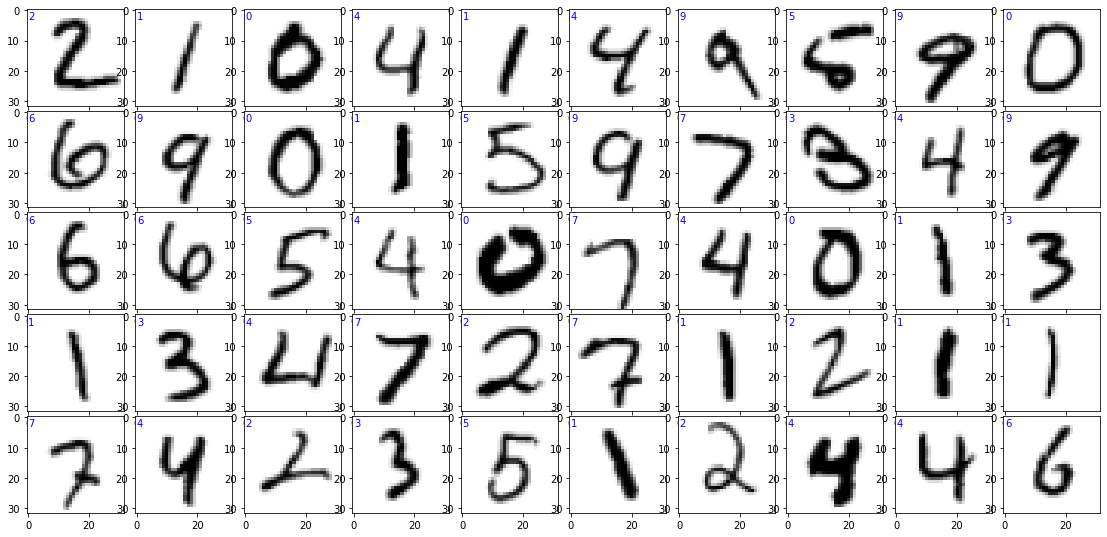

In [117]:
fig = plt.figure(figsize=(15, 7))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(1, ROW_IMG * N_ROWS + 1):
    # ax = fig.add_subplot(5, 10, i + 1, xticks=[], yticks=[])
    ax = fig.add_subplot(N_ROWS, ROW_IMG, i)
    ax.imshow(images_np[i], cmap=plt.cm.gray_r, interpolation='nearest')
    if labels[i] == torch.max(preds[i], 0)[1]:
      ax.text(0, 3, class_names[torch.max(preds[i], 0)[1]], color='blue')
    else:
      ax.text(0, 3, class_names[torch.max(preds[i], 0)[1]], color='red')

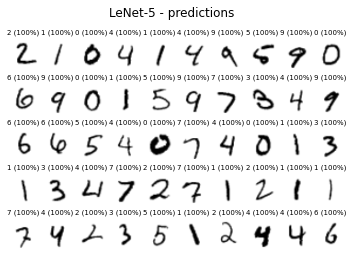

In [118]:
ROW_IMG = 10
N_ROWS = 5
images_np = [i.mean(dim=0).cpu().numpy() for i in images]

with torch.no_grad():
        images, labels = images.to(device), labels.to(device)
        preds = model(images)
fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(images_np[index], cmap='gray_r')
    title = f'{torch.argmax(preds[index])} ({torch.max(preds[index] * 100):.0f}%)'
    
    plt.title(title, fontsize=7)
fig.suptitle('LeNet-5 - predictions');
    